In [1]:
import os
os.chdir('../')

from cdrift import helpers
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path
def loadDataframes(baseDir):
    # bose_dir = "testAll/Bose/evaluation_results.csv"
    bose_dir = Path(baseDir,"Bose/evaluation_results.csv")
    b = helpers.readCSV_Lists(bose_dir)
    b["Algorithm/Options"] = b["Algorithm/Options"].apply(
        lambda x: 
        "Bose J" if x == "Bose Average J" 
        else "Bose WC" if x == "Bose Average WC" 
        else "Bose ???"
    )

    b_j = b[b["Algorithm/Options"] == "Bose J"]
    b_wc = b[b["Algorithm/Options"] == "Bose WC"]

    martjushev_dir = Path(baseDir,"Martjushev/evaluation_results.csv")
    m = helpers.readCSV_Lists(martjushev_dir)
    m["Algorithm/Options"] = m["Algorithm/Options"].apply(
        lambda x: 
        "Martjushev J" if x == "Martjushev Recursive Bisection; Average J; p=0.55"
        else "Martjushev WC" if x == "Martjushev Recursive Bisection; Average WC; p=0.55" 
        else "Martjushev ???"
    )
    m_j = m[m["Algorithm/Options"] == "Martjushev J"]
    m_wc = m[m["Algorithm/Options"] == "Martjushev WC"]

    em_dir = Path(baseDir,"Earthmover/evaluation_results.csv")
    em = helpers.readCSV_Lists(em_dir)

    prodrift_dir = Path(baseDir, "Maaradji/evaluation_results.csv")
    prodrift = helpers.readCSV_Lists(prodrift_dir)
    prodrift["Algorithm/Options"] = prodrift["Algorithm/Options"].apply(lambda x: "ProDrift")

    pgraph_dir = Path(baseDir, "ProcessGraph/evaluation_results.csv")
    pgraphs = helpers.readCSV_Lists(pgraph_dir)
    pgraphs["Algorithm/Options"] = pgraphs["Algorithm/Options"].apply(lambda x: "Process Graphs")

    zheng_dir = Path(baseDir, "Zheng/evaluation_results.csv")
    zheng = helpers.readCSV_Lists(zheng_dir)
    zheng["Algorithm/Options"] = zheng["Algorithm/Options"].apply(lambda x: "Zheng")

    dataframes = [b_j, b_wc, m_j, m_wc, prodrift, em, pgraphs, zheng]
    return dataframes
# b = helpers.readCSV_Lists("testAll/Bose/evaluation_results.csv")
# b["Algorithm/Options"] = b["Algorithm/Options"].apply(
#     lambda x: 
#     "Bose J" if x == "Bose Average J" 
#     else "Bose WC" if x == "Bose Average WC" 
#     else "Bose ???"
# )

# b_j = b[b["Algorithm/Options"] == "Bose J"]
# b_wc = b[b["Algorithm/Options"] == "Bose WC"]

# m = pd.read_csv("testAll/Martjushev/evaluation_results.csv", converters={"Duration":lambda x: timedelta(seconds=float(x))})
# m["Algorithm/Options"] = m["Algorithm/Options"].apply(
#     lambda x: 
#     "Martjushev J" if x == "Martjushev Recursive Bisection; Average J; p=0.65"
#      else "Martjushev WC" if x == "Martjushev Recursive Bisection; Average WC; p=0.65" 
#      else "Martjushev ???"
# )
# m_j = m[m["Algorithm/Options"] == "Martjushev J"]
# m_wc = m[m["Algorithm/Options"] == "Martjushev WC"]

# em = helpers.readCSV_Lists("testAll/Earthmover/evaluation_results.csv")

# prodrift = helpers.readCSV_Lists("testAll/Maaradji/evaluation_results.csv")
# prodrift["Algorithm/Options"] = prodrift["Algorithm/Options"].apply(lambda x: "ProDrift")

# pgraphs = helpers.readCSV_Lists("testAll/ProcessGraph/evaluation_results.csv")
# pgraphs["Algorithm/Options"] = pgraphs["Algorithm/Options"].apply(lambda x: "Process Graphs")

# zheng = helpers.readCSV_Lists("testAll/Zheng/evaluation_results.csv")
# zheng["Algorithm/Options"] = zheng["Algorithm/Options"].apply(lambda x: "Zheng")

# dataframes = [b_j, b_wc, m_j, m_wc, prodrift, em, pgraphs, zheng]

In [4]:
def getScatterPoints(baseDir, HANDLE_NAN_AS=0):
    points = []
    dataframes = loadDataframes(baseDir)
    for df in dataframes:
        avgDur = helpers.calcAvgDuration(df).seconds
        avgF1 = df["F1-Score"].fillna(HANDLE_NAN_AS, inplace=False).mean()
        name = df.iloc[-1]["Algorithm/Options"]
        points.append({
            "Duration": avgDur/60,
            "F1-Score": avgF1,
            "Algorithm": name,
        })
    return points

In [5]:
markers = {
    "Bose J": "^", # triangle_up
    "Bose WC": "^", # triangle_up
    "Martjushev J": "s", # square
    "Martjushev WC": "s", #square
}
colors = {
    "Bose J": "#add8e6", # Light Blue
    "Bose WC": "#000080", # Navy Blue
    "Martjushev J": "#32cd32", # Navy Green
    "Martjushev WC": "#006400", # Dark Green
    "ProDrift": "#ff0000", # Red
    "Earth Mover's Distance": "#ffa500", # Orange
    "Process Graphs": "#ddcd10", # Some dark, rich yellow
    "Zheng": "#800080" # Purple
    # The rest is just whatever it wants to give them
}
def scatter(points):
    plt.rcParams['figure.figsize']=(8,5)
    fig,ax = plt.subplots()
    for point in points:
        label = point["Algorithm"]
        color = colors.get(label, None),
        marker = markers.get(label, None)
        ax.scatter(y=[point["F1-Score"]], x=[point["Duration"]], label=label, color=color, marker=marker)
    ax.set_ylabel("Mean F1-Score")
    ax.set_ylim(-0.02,1)
    ax.set_xlabel("Mean Duration (Minutes)")
    ax.legend(bbox_to_anchor=(1,1), loc="upper left", title="Algorithm")
    ax.grid(True)
    # plt.savefig("scatter_fig_600dpi.png", bbox_inches='tight', dpi=600)
    # plt.show()

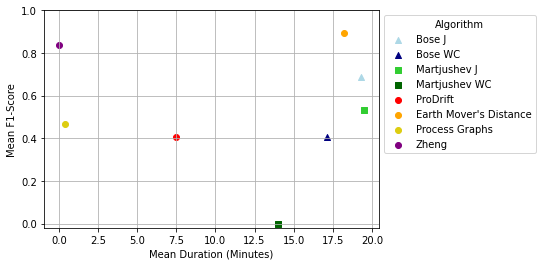

In [6]:
points = getScatterPoints("testAll", HANDLE_NAN_AS=0)
scatter(points)
plt.show()

In [7]:

# Find the paretos #
def scatterPareto(points):
    paretos = []
    for idx, point in enumerate(points):
        dur = point["Duration"]
        f1 = point["F1-Score"]
        others = [p for p in points if p != point]
        if all([not (x["Duration"] < dur and x["F1-Score"] > f1) for x in others]):
        # if all([x["Duration"] >= dur for x in others]) or all([x["F1-Score"] <= f1 for x in others]):
            # If all algorithms take longer or  have a worse f1-score
            # This means that no point exists that is better in both dimensions simultaneously
            # This point is part of the pareto-front
            paretos.append(point)


    # colors = {
    #     point["Algorithm"]: "#808080" if point not in paretos else None
    #     for point in points
    # }
    paretos = sorted(paretos,key=lambda x: (x["Duration"], x["F1-Score"]))


    # Draw Scatter Points
    fig,ax = plt.subplots()
    for point in points:
        label = point["Algorithm"]
        color = colors.get(label, None)
        marker = markers.get(label, None)
        ax.scatter(y=[point["F1-Score"]], x=[point["Duration"]], label=label, color=color, marker=marker, zorder=2)
    ax.set_ylabel("Mean F1-Score")
    ax.set_ylim(-0.02,1)
    ax.set_xlabel("Mean Duration (Minutes)")
    ax.legend(bbox_to_anchor=(1,1), loc="upper left", title="Algorithm")
    ax.grid(True)

    # Draw pareto line
    ax.plot([0,paretos[0]["Duration"]], [0, paretos[0]["F1-Score"]], "red", linestyle=":", zorder=1)
    for i in range(len(paretos)-1):
        p1 = paretos[i]
        p2 = paretos[i+1]
        p1_x = p1["Duration"]
        p2_x = p2["Duration"]
        p1_y = p1["F1-Score"]
        p2_y = p2["F1-Score"]

        xs = [p1_x, p2_x]
        ys = [p1_y, p2_y]

        ax.plot(xs, ys, "red", linestyle=":", zorder=1)
    xlim_before = ax.get_xlim()
    ub = ax.get_xlim()[1]*2
    ax.plot([paretos[-1]["Duration"], ub], [paretos[-1]["F1-Score"],paretos[-1]["F1-Score"]], "red", linestyle=":", zorder=1)
    ax.set_xlim(xlim_before)
    # print(paretos[-1]["Duration"])
    # print(paretos[-1]["F1-Score"])
    # plt.axhline(xmin=paretos[-1]["Duration"], y=paretos[-1]["F1-Score"], color="black", linestyle="--")

In [8]:
points_noiseless = getScatterPoints("testAll", HANDLE_NAN_AS=0)
points_noisy = getScatterPoints("testAll_Noisy", HANDLE_NAN_AS=0)

points_noiseless

points_noisy

[{'Duration': 25.6, 'F1-Score': 0.7957264957264956, 'Algorithm': 'Bose J'},
 {'Duration': 30.55, 'F1-Score': 0.54017094017094, 'Algorithm': 'Bose WC'},
 {'Duration': 25.8,
  'F1-Score': 0.5499999999999999,
  'Algorithm': 'Martjushev J'},
 {'Duration': 25.866666666666667,
  'F1-Score': 0.0,
  'Algorithm': 'Martjushev WC'},
 {'Duration': 4.766666666666667,
  'F1-Score': 0.057692307692307696,
  'Algorithm': 'ProDrift'},
 {'Duration': 19.716666666666665,
  'F1-Score': 0.9077533577533577,
  'Algorithm': "Earth Mover's Distance"},
 {'Duration': 0.65,
  'F1-Score': 0.7478632478632478,
  'Algorithm': 'Process Graphs'},
 {'Duration': 0.05, 'F1-Score': 0.019230769230769232, 'Algorithm': 'Zheng'}]

large


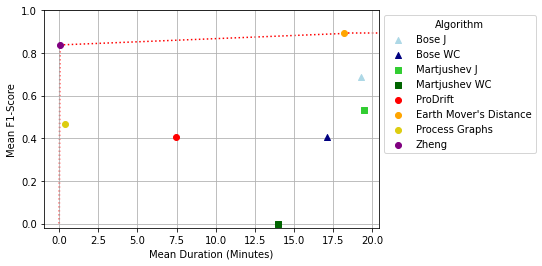

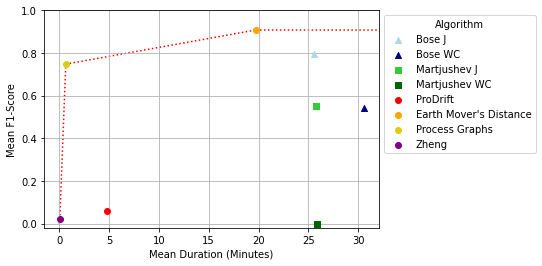

In [9]:
print(plt.rcParams["axes.titlesize"])
# plt.rc('axes', titlesize=)     # fontsize of the axes title
scatterPareto(points_noiseless)
plt.savefig("scatter_noiseless.pdf",format="pdf",bbox_inches='tight')
plt.show()

scatterPareto(points_noisy)
plt.savefig("scatter_noisy.pdf",format="pdf",bbox_inches='tight')
plt.show()